In [ ]:
# import pandas as pd
import os
import seaborn as sns
#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement

In [2]:
import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

In [4]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [183]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']


In [6]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [7]:
class WrongRank(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [181]:
def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    print(df.head())
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]

    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values
    table = table.fillna(0)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]
    results = ancom(table_repl, grouping_ser)
    return results

In [44]:
def analyse(dataset_name, table_files, column_to_group = "STUDY_CONDITION", rank='F', 
            use_percent = False, percent=30, group=None):
    result_df, percentile_df = get_table_and_grouping(dataset_name, table_files,
                                                  column_to_group,
                                                  rank, use_percent, percent, group)
    differences = list(result_df.loc[[i for i in result_df["Reject null hypothesis"]]].index)
    print("------------------- RESULTS ------------------- ")
    df_list = []
    for d in differences:
        df = pd.DataFrame(percentile_df[50.0].loc[d])
        df_list.append(df.transpose())
    try:
        df_dataset = pd.concat(df_list)
    except:
        return differences
    
    unpivot = pd.DataFrame(df_dataset.unstack(level=1))
    unpivot = unpivot.reset_index()
    unpivot["Abundance"] = unpivot[0]
    unpivot["Name"] = unpivot['level_1']
    unpivot = unpivot.drop(columns=[0, 'level_1'])
    
    print(unpivot)
    
    g = sns.catplot(x="Name", y="Abundance", hue="Group", data=unpivot,
                kind="bar", palette="muted")
    return result_df, percentile_df, unpivot

In [167]:
def run(dataset_name, method, rank, percent, selected_list = None):
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Mthod should be 'Kraken' or 'Metaphlan'")
            raise 
            
    x = df_dataset_ChngKR_2016_kraken = analyse(dataset_name, table_files = table_files,
                     column_to_group = "STUDY_CONDITION", rank=rank, use_percent = True, percent=percent)
    result_df = x[0]
    percentile_df = x[1]

    columns = result_df.shape[0]
    thrashold = round(columns/10)
    print("Thrashold:", thrashold)
    
    if selected_list is not None:
        differences = selected_list
    else:
        differences = list(result_df.loc[result_df["W"] > thrashold].index)
    print(differences)
    print(result_df.loc[result_df["W"] > thrashold].sort_values('W',ascending = False))
    
    #differences.sort()
    print("------------------- NOT RELEVANT(?) RESULTS ------------------- ")
    df_list = []
    for d in differences:
        df = pd.DataFrame(percentile_df[50.0].loc[d])
        df_list.append(df.transpose())

        df_dataset = pd.concat(df_list)


    unpivot = pd.DataFrame(df_dataset.unstack(level=1))
    unpivot = unpivot.reset_index()
    unpivot["Abundance"] = unpivot[0]
    unpivot["Name"] = unpivot['level_1']
    unpivot = unpivot.drop(columns=[0, 'level_1'])
    print(unpivot)
    
    unpivot_scaled = unpivot
    
    grouped = unpivot_scaled[["Name", "Abundance"]].groupby("Name").sum()
    print(grouped)
    
    unpivot_scaled["Propotion"] = 0
    
    def scale(row):
        name = row.Name
        summed = float(grouped.loc[grouped.index == name]["Abundance"])
        row.Propotion = row.Abundance / summed * 100
        return row
    
    unpivot_scaled = unpivot_scaled.apply(scale, axis=1)
    
    g = sns.catplot(x="Name", y="Propotion", hue="Group", data=unpivot_scaled,
                kind="bar", palette="muted")
    g.set_xticklabels(rotation=90)
    

Shape of table: (154, 12)
------------------- RESULTS ------------------- 
      Group  Abundance            Name
0       CRC   0.075636  Actinobacteria
1       CRC   0.101631   Bacteroidetes
2       CRC   0.535826      Firmicutes
3       CRC   0.006863    Fusobacteria
4       CRC   0.011477  Proteobacteria
5   adenoma   0.084696  Actinobacteria
6   adenoma   0.047714   Bacteroidetes
7   adenoma   0.663614      Firmicutes
8   adenoma   0.006944    Fusobacteria
9   adenoma   0.002798  Proteobacteria
10  control   0.142451  Actinobacteria
11  control   0.025896   Bacteroidetes
12  control   0.684980      Firmicutes
13  control   0.006944    Fusobacteria
14  control   0.005007  Proteobacteria
Thrashold: 1
                W  Reject null hypothesis
Name                                     
Fusobacteria    5                    True
Bacteroidetes   3                    True
Firmicutes      3                    True
Proteobacteria  3                    True
Actinobacteria  2                   

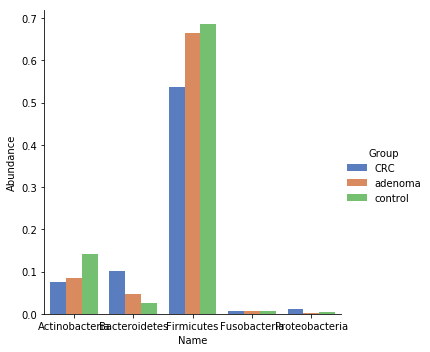

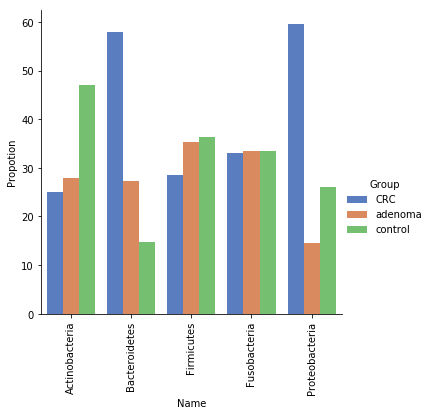

In [129]:
run("FengQ_2015", "Metaphlan", "P", 30)

Shape of table: (154, 42)
------------------- RESULTS ------------------- 
     Group  Abundance          Name
0      CRC   0.000624  Fusobacteria
1  adenoma   0.000561  Fusobacteria
2  control   0.000391  Fusobacteria
Thrashold: 4
               W  Reject null hypothesis
Name                                    
Fusobacteria  36                    True
Firmicutes     5                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
     Group  Abundance          Name
0      CRC   0.438806    Firmicutes
1      CRC   0.000624  Fusobacteria
2  adenoma   0.500320    Firmicutes
3  adenoma   0.000561  Fusobacteria
4  control   0.583976    Firmicutes
5  control   0.000391  Fusobacteria
              Abundance
Name                   
Firmicutes     1.523102
Fusobacteria   0.001576


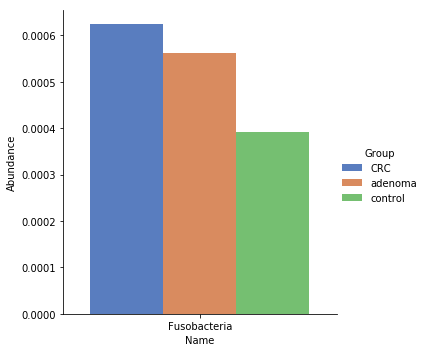

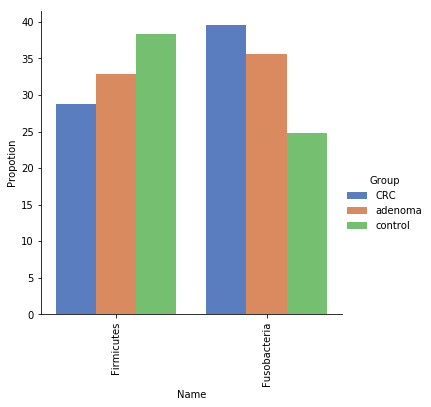

In [130]:
run("FengQ_2015", "Kraken", "P", 30)

Shape of table: (154, 20)
------------------- RESULTS ------------------- 
     Group  Abundance           Name
0      CRC   0.102871    Bacteroidia
1      CRC   0.002500  Fusobacteriia
2      CRC   0.016692  Negativicutes
3  adenoma   0.048668    Bacteroidia
4  adenoma   0.002500  Fusobacteriia
5  adenoma   0.012102  Negativicutes
6  control   0.026224    Bacteroidia
7  control   0.002500  Fusobacteriia
8  control   0.001688  Negativicutes
Thrashold: 2
                       W  Reject null hypothesis
Name                                            
Bacteroidia            8                    True
Negativicutes          6                    True
Fusobacteriia          5                    True
Bacilli                3                   False
Epsilonproteobacteria  3                   False
Gammaproteobacteria    3                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
      Group  Abundance                   Name
0       CRC   0.007150                B

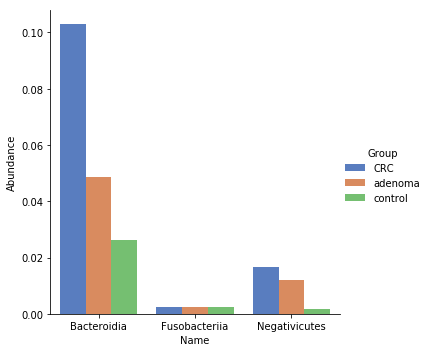

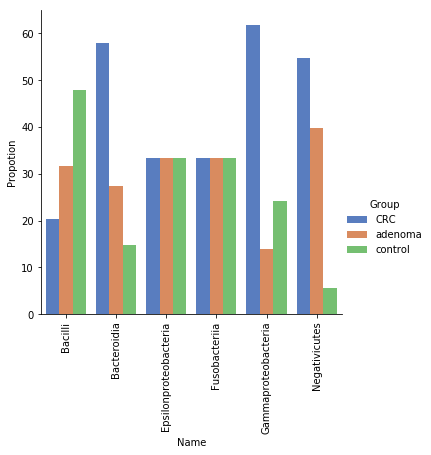

In [131]:
run("FengQ_2015", "Metaphlan", "C", 30)

Shape of table: (154, 81)
------------------- RESULTS ------------------- 
       Group  Abundance                         Name
0        CRC   0.000152               Acidimicrobiia
1        CRC   0.000152            Acidithiobacillia
2        CRC   0.000152  Acidobacteria subdivision 6
3        CRC   0.000152               Acidobacteriia
4        CRC   0.044202               Actinobacteria
5        CRC   0.002892          Alphaproteobacteria
6        CRC   0.000152                 Anaerolineae
7        CRC   0.000152                    Aquificae
8        CRC   0.000152                 Archaeoglobi
9        CRC   0.000152               Ardenticatenia
10       CRC   0.023241                      Bacilli
11       CRC   0.164763                  Bacteroidia
12       CRC   0.002046           Betaproteobacteria
13       CRC   0.000152               Blastocatellia
14       CRC   0.000152                  Caldilineae
15       CRC   0.000152                 Caldisericia
16       CRC   0.000152 

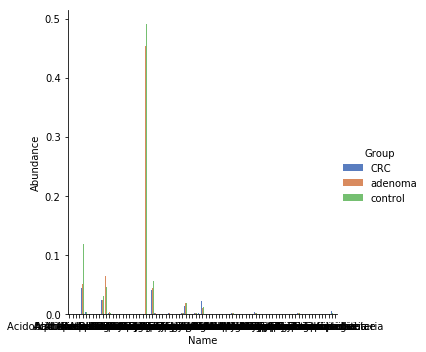

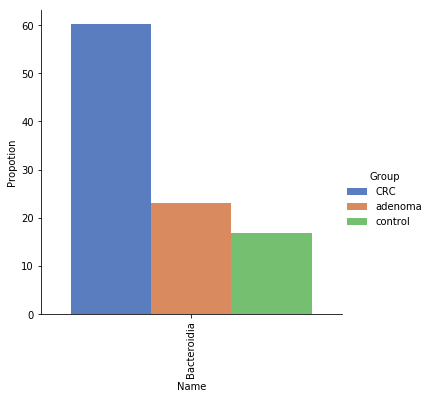

In [132]:
run("FengQ_2015", "Kraken", "C", 30)

Shape of table: (154, 50)
------------------- RESULTS ------------------- 
     Group  Abundance                Name
0      CRC   0.010524  Porphyromonadaceae
1  adenoma   0.002855  Porphyromonadaceae
2  control   0.002226  Porphyromonadaceae
Thrashold: 5
                     W  Reject null hypothesis
Name                                          
Porphyromonadaceae  34                    True
Lactobacillaceae     7                   False
Rikenellaceae        7                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
     Group  Abundance                Name
0      CRC   0.000400    Lactobacillaceae
1      CRC   0.010524  Porphyromonadaceae
2      CRC   0.014762       Rikenellaceae
3  adenoma   0.000400    Lactobacillaceae
4  adenoma   0.002855  Porphyromonadaceae
5  adenoma   0.006274       Rikenellaceae
6  control   0.000768    Lactobacillaceae
7  control   0.002226  Porphyromonadaceae
8  control   0.003613       Rikenellaceae
                    Abun

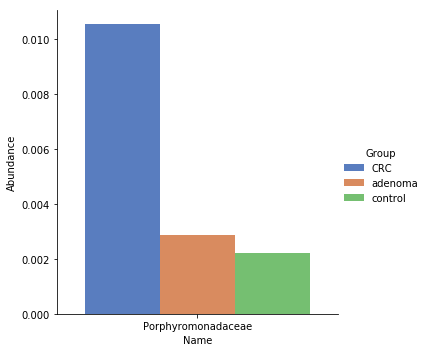

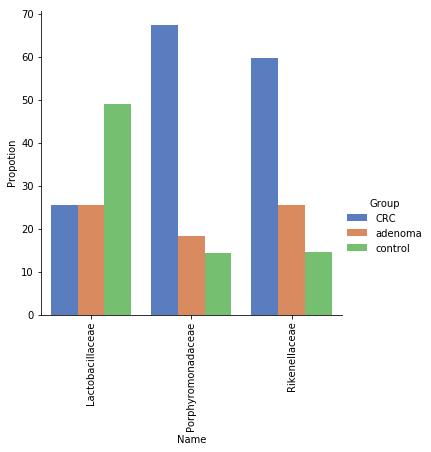

In [133]:
run("FengQ_2015", "Metaphlan", "F", 30)

Shape of table: (154, 371)
------------------- RESULTS ------------------- 
     Group  Abundance                Name
0      CRC   0.000473  Porphyromonadaceae
1  adenoma   0.000007  Porphyromonadaceae
2  control   0.000007  Porphyromonadaceae
Thrashold: 37
                      W  Reject null hypothesis
Name                                           
Porphyromonadaceae  358                    True
------------------- NOT RELEVANT(?) RESULTS ------------------- 
     Group  Abundance                Name
0      CRC   0.000473  Porphyromonadaceae
1  adenoma   0.000007  Porphyromonadaceae
2  control   0.000007  Porphyromonadaceae
                    Abundance
Name                         
Porphyromonadaceae   0.000487


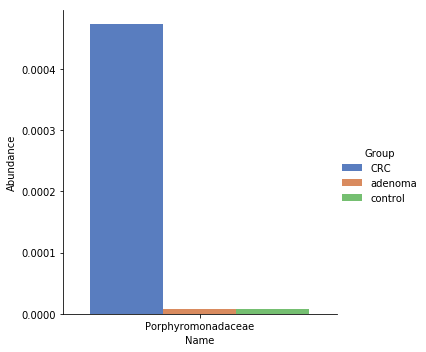

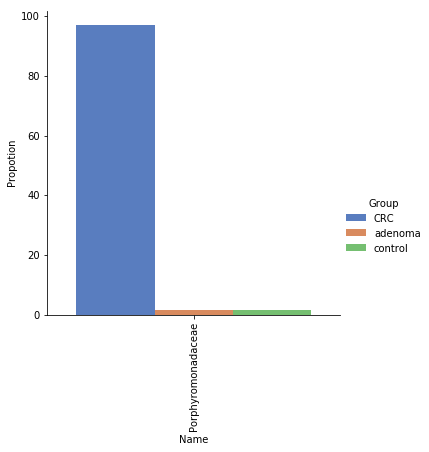

In [134]:
run("FengQ_2015", "Kraken", "F", 30)

Shape of table: (154, 84)
------------------- RESULTS ------------------- 
     Group  Abundance        Name
0      CRC   0.000312  Prevotella
1  adenoma   0.000142  Prevotella
2  control   0.000142  Prevotella
Thrashold: 8
                  W  Reject null hypothesis
Name                                       
Prevotella       41                    True
Parabacteroides  14                   False
Porphyromonas    11                   False
Alistipes         9                   False
Gemella           9                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
      Group  Abundance             Name
0       CRC   0.014832        Alistipes
1       CRC   0.000142          Gemella
2       CRC   0.004593  Parabacteroides
3       CRC   0.000142    Porphyromonas
4       CRC   0.000312       Prevotella
5   adenoma   0.006310        Alistipes
6   adenoma   0.000142          Gemella
7   adenoma   0.000554  Parabacteroides
8   adenoma   0.000142    Porphyromonas
9  

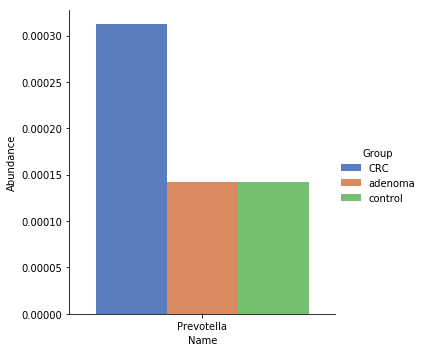

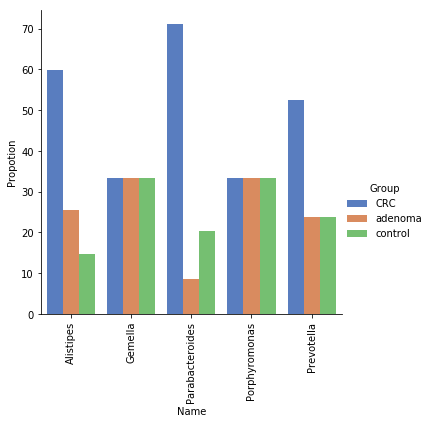

In [135]:
run("FengQ_2015", "Metaphlan", "G", 30)

Shape of table: (154, 152)
------------------- RESULTS ------------------- 
     Group  Abundance           Name
0      CRC   0.000261  Porphyromonas
1  adenoma   0.000043  Porphyromonas
2  control   0.000043  Porphyromonas
Thrashold: 15
                 W  Reject null hypothesis
Name                                      
Porphyromonas  134                    True
Parvimonas     109                   False
Prevotella     103                   False
Gemella        100                   False
Odoribacter     26                   False
Blautia         19                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
      Group  Abundance           Name
0       CRC   0.007041        Blautia
1       CRC   0.000043        Gemella
2       CRC   0.001884    Odoribacter
3       CRC   0.000043     Parvimonas
4       CRC   0.000261  Porphyromonas
5       CRC   0.001656     Prevotella
6   adenoma   0.013658        Blautia
7   adenoma   0.000043        Gemella
8   adenoma

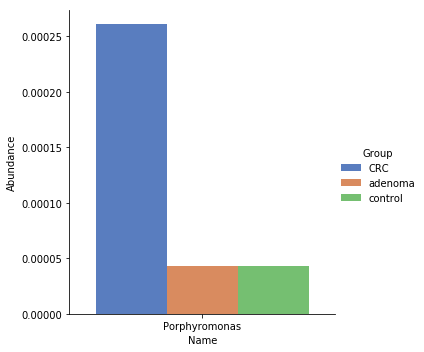

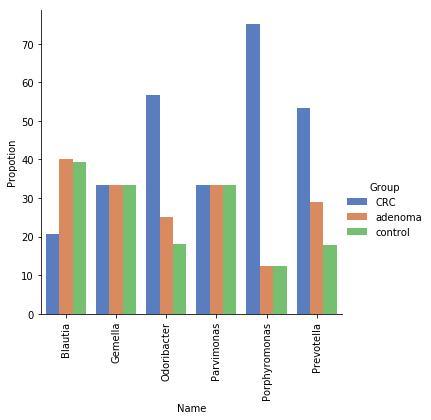

In [136]:
run("FengQ_2015", "Kraken", "G", 10)

Shape of table: (154, 168)
------------------- RESULTS ------------------- 
      Group  Abundance                           Name
0       CRC   0.000035        Fusobacterium nucleatum
1       CRC   0.000035               Parvimonas micra
2       CRC   0.000035  Porphyromonas asaccharolytica
3       CRC   0.000562          Prevotella intermedia
4   adenoma   0.000035        Fusobacterium nucleatum
5   adenoma   0.000035               Parvimonas micra
6   adenoma   0.000035  Porphyromonas asaccharolytica
7   adenoma   0.000035          Prevotella intermedia
8   control   0.000035        Fusobacterium nucleatum
9   control   0.000035               Parvimonas micra
10  control   0.000035  Porphyromonas asaccharolytica
11  control   0.000035          Prevotella intermedia
Thrashold: 17
                                 W  Reject null hypothesis
Name                                                      
Porphyromonas asaccharolytica  112                    True
Prevotella intermedia          

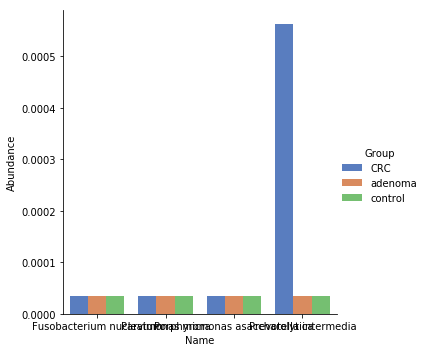

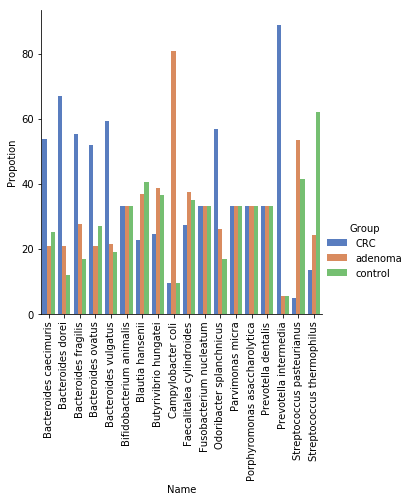

In [146]:
run("FengQ_2015", "Kraken", "S", 3)

Shape of table: (154, 294)
------------------- RESULTS ------------------- 
     Group  Abundance              Name
0      CRC   0.000143  Prevotella_copri
1  adenoma   0.000012  Prevotella_copri
2  control   0.000012  Prevotella_copri
Thrashold: 29
                                       W  Reject null hypothesis
Name                                                            
Prevotella_copri                     199                    True
Parvimonas_unclassified              133                   False
Fusobacterium_nucleatum              108                   False
Gemella_morbillorum                  104                   False
Porphyromonas_asaccharolytica         91                   False
Peptostreptococcus_stomatis           72                   False
Porphyromonas_somerae                 68                   False
Parvimonas_micra                      49                   False
Ruminococcaceae_bacterium_D16         49                   False
Porphyromonas_uenonis              

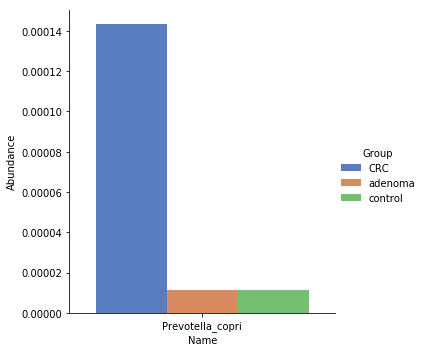

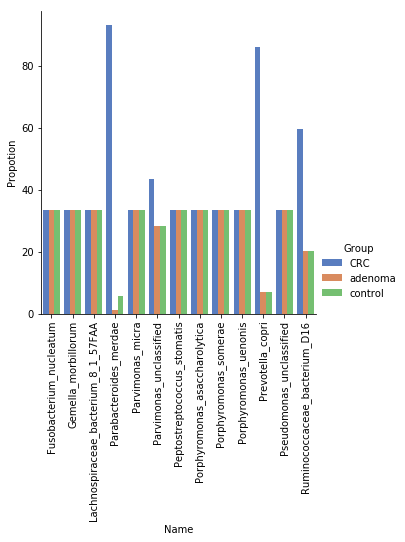

In [147]:
run("FengQ_2015", "Metaphlan", "S", 3)

In [ ]:
Learning_features = ["Firmicutes", "Fusobacteria", "Bacteroidia", "Porphyromonadaceae", "Gemella",
                     "Porphyromonas", "Prevotella", "Fusobacterium nucleatum"]

Fusobacterium nucleatum - Fusobacteria
Porphyromonas - Porphyromonadaceae
Gemella - Firmicutes 

# VogtmannE_2016

Shape of table: (417, 15)
------------------- RESULTS ------------------- 
     Group  Abundance          Name
0      CRC   0.004444  Fusobacteria
1  control   0.004444  Fusobacteria
Thrashold: 2
                              W  Reject null hypothesis
Name                                                   
Fusobacteria                 14                    True
Proteobacteria               11                   False
Spirochaetes                  6                   False
Viruses_noname                5                   False
Acidobacteria                 4                   False
Deferribacteres               4                   False
Firmicutes                    4                   False
Synergistetes                 4                   False
Ascomycota                    3                   False
Candidatus_Saccharibacteria   3                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
      Group  Abundance                         Name
0       CRC   0

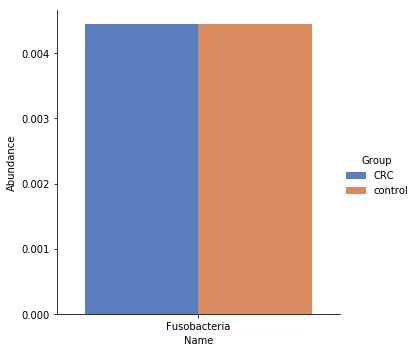

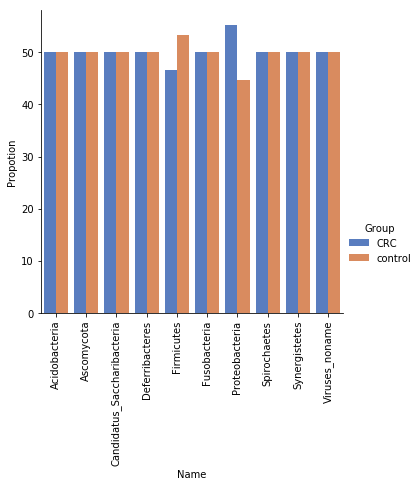

In [149]:
run("VogtmannE_2016", "Metaphlan", "P", 30)

Shape of table: (417, 42)
------------------- RESULTS ------------------- 
     Group  Abundance          Name
0      CRC   0.000464  Fusobacteria
1      CRC   0.000364   Tenericutes
2  control   0.000387  Fusobacteria
3  control   0.000375   Tenericutes
Thrashold: 4
                 W  Reject null hypothesis
Name                                      
Fusobacteria    38                    True
Tenericutes     31                    True
Cyanobacteria   27                   False
Chordata         8                   False
Proteobacteria   6                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
     Group  Abundance            Name
0      CRC   0.000854        Chordata
1      CRC   0.000550   Cyanobacteria
2      CRC   0.000464    Fusobacteria
3      CRC   0.019507  Proteobacteria
4      CRC   0.000364     Tenericutes
5  control   0.000781        Chordata
6  control   0.000601   Cyanobacteria
7  control   0.000387    Fusobacteria
8  control   0.019543  P

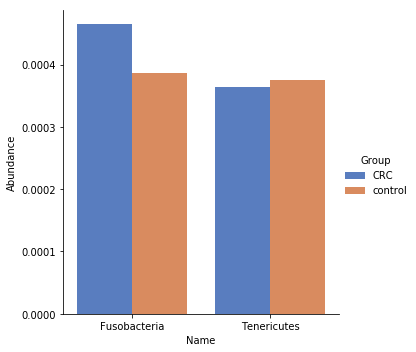

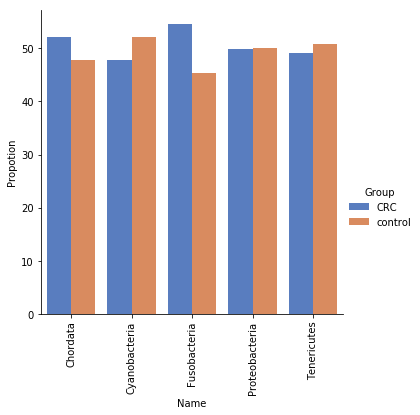

In [152]:
run("VogtmannE_2016", "Kraken", "P", 30)

Shape of table: (417, 20)
------------------- RESULTS ------------------- 
     Group  Abundance                 Name
0      CRC   0.003624  Deltaproteobacteria
1      CRC   0.011108     Erysipelotrichia
2  control   0.002500  Deltaproteobacteria
3  control   0.004237     Erysipelotrichia
Thrashold: 2
                        W  Reject null hypothesis
Name                                             
Erysipelotrichia       12                    True
Deltaproteobacteria    10                    True
Fusobacteriia           7                   False
Spirochaetia            7                   False
Gammaproteobacteria     6                   False
Clostridia              5                   False
Epsilonproteobacteria   5                   False
Synergistia             5                   False
Deferribacteres         4                   False
Acidobacteriia          3                   False
Bacilli                 3                   False
Bacteroidia             3                   Fal

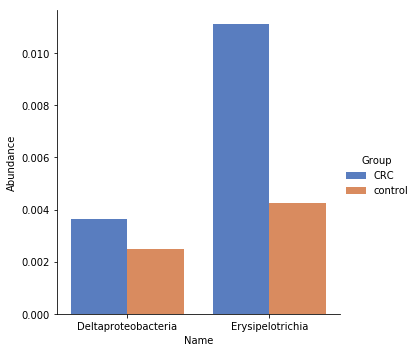

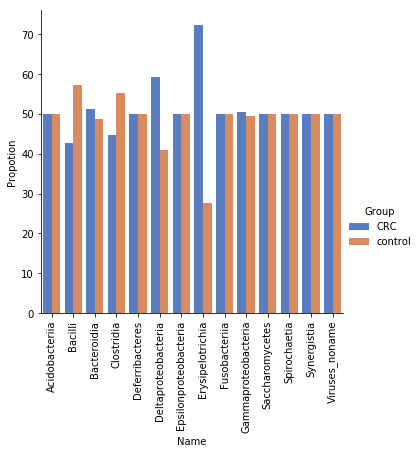

In [150]:
run("VogtmannE_2016", "Metaphlan", "C", 30)

Shape of table: (417, 81)
------------------- RESULTS ------------------- 
     Group  Abundance        Name
0      CRC   0.000255  Mollicutes
1  control   0.000304  Mollicutes
Thrashold: 8
                      W  Reject null hypothesis
Name                                           
Mollicutes           69                    True
Methanomicrobia      52                   False
Thermotogae          50                   False
Fusobacteriia        16                   False
Mammalia             13                   False
Gammaproteobacteria   9                   False
Tissierellia          9                   False
------------------- NOT RELEVANT(?) RESULTS ------------------- 
      Group  Abundance                 Name
0       CRC   0.000311        Fusobacteriia
1       CRC   0.008291  Gammaproteobacteria
2       CRC   0.000870             Mammalia
3       CRC   0.000152      Methanomicrobia
4       CRC   0.000255           Mollicutes
5       CRC   0.000152          Thermotogae
6    

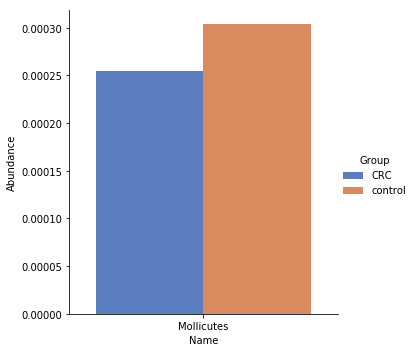

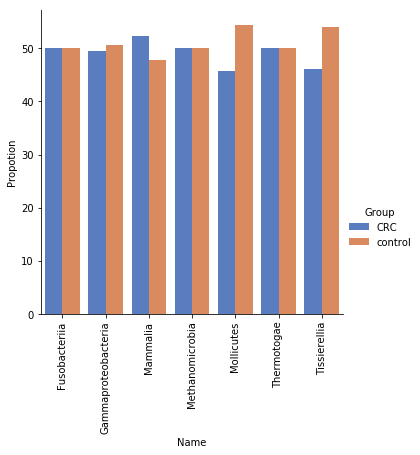

In [153]:
run("VogtmannE_2016", "Kraken", "C", 30)

Shape of table: (417, 388)
------------------- RESULTS ------------------- 
     Group  Abundance                                               Name
0      CRC   0.000007                                   Mycoplasmataceae
1      CRC   0.000007                                      Neisseriaceae
2      CRC   0.000454                                 Porphyromonadaceae
3      CRC   0.000007                            Thermoanaerobacteraceae
4      CRC   0.000007  Thermoanaerobacterales Family III. Incertae Sedis
5  control   0.000007                                   Mycoplasmataceae
6  control   0.000007                                      Neisseriaceae
7  control   0.000408                                 Porphyromonadaceae
8  control   0.000007                            Thermoanaerobacteraceae
9  control   0.000007  Thermoanaerobacterales Family III. Incertae Sedis
Thrashold: 39
                                                     W  Reject null hypothesis
Name                        

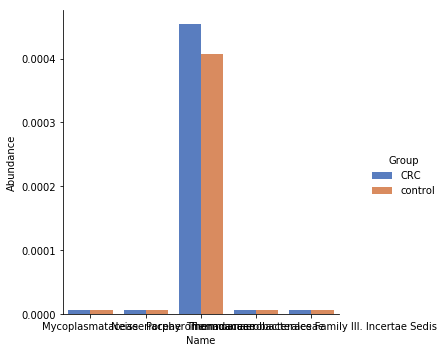

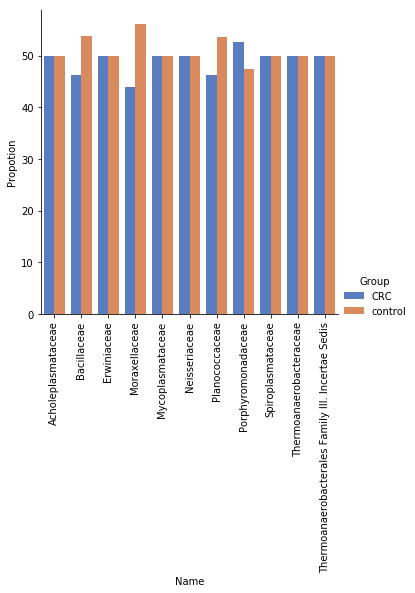

In [154]:
run("VogtmannE_2016", "Kraken", "F", 30)

Shape of table: (417, 44)
------------------- RESULTS ------------------- 
     Group  Abundance                  Name
0      CRC   0.002459    Acidaminococcaceae
1      CRC   0.000517  Bacteroidales_noname
2  control   0.000517    Acidaminococcaceae
3  control   0.001795  Bacteroidales_noname
Thrashold: 4
                                         W  Reject null hypothesis
Name                                                              
Bacteroidales_noname                    31                    True
Acidaminococcaceae                      27                    True
Erysipelotrichaceae                     19                   False
Desulfovibrionaceae                     18                   False
Enterobacteriaceae                      17                   False
Clostridiales_Family_XI_Incertae_Sedis  14                   False
Ruminococcaceae                         11                   False
Clostridiales_noname                    11                   False
Micrococcaceae        

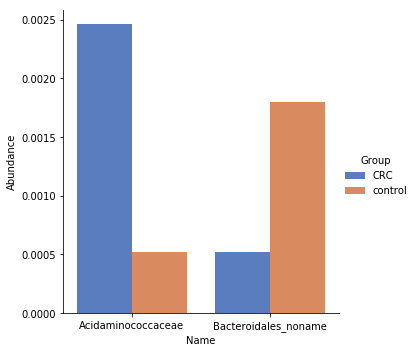

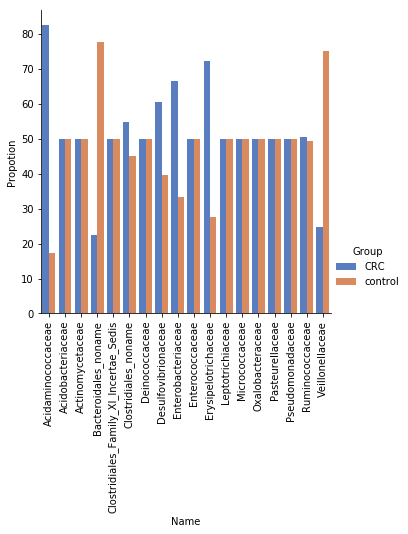

In [155]:
run("VogtmannE_2016", "Metaphlan", "F", 30)

Escherichia, Porphyromonas, Adlercreutzia, Rothia, Citrobacter, Butyrivibrio, Desulfovibrio, Blautia, Actinomyces, Turicibacter, Faecalibacterium, Pseudomonas

In [163]:
l = ["Escherichia", "Porphyromonas", "Adlercreutzia", "Rothia",
"Citrobacter", "Butyrivibrio", "Desulfovibrio", "Blautia", "Actinomyces", 
     "Turicibacter", "Faecalibacterium", "Pseudomonas"]


Shape of table: (417, 92)
------------------- RESULTS ------------------- 
     Group  Abundance           Name
0      CRC   0.000837    Escherichia
1      CRC   0.000338  Porphyromonas
2  control   0.000356    Escherichia
3  control   0.000318  Porphyromonas
Thrashold: 9
                      W  Reject null hypothesis
Name                                           
Escherichia          90                    True
Porphyromonas        86                    True
Adlercreutzia        80                   False
Parvimonas           72                   False
Mogibacterium        50                   False
Vibrio               38                   False
Roseburia            37                   False
Rothia               37                   False
Homo                 34                   False
Citrobacter          30                   False
Butyrivibrio         29                   False
Aeromonas            29                   False
Gordonibacter        28                   False
Desulfo

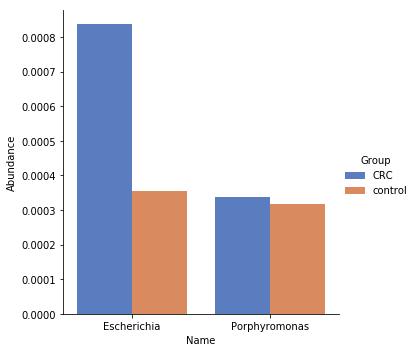

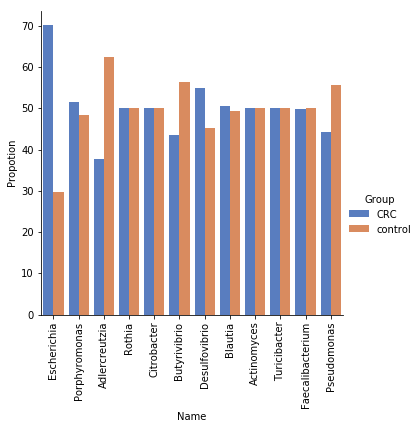

In [165]:
run("VogtmannE_2016", "Kraken", "G", 30, l)

Shape of table: (417, 92)
------------------- RESULTS ------------------- 
     Group  Abundance           Name
0      CRC   0.000837    Escherichia
1      CRC   0.000338  Porphyromonas
2  control   0.000356    Escherichia
3  control   0.000318  Porphyromonas
Thrashold: 9
                      W  Reject null hypothesis
Name                                           
Escherichia          90                    True
Porphyromonas        86                    True
Adlercreutzia        80                   False
Parvimonas           72                   False
Mogibacterium        50                   False
Vibrio               38                   False
Roseburia            37                   False
Rothia               37                   False
Homo                 34                   False
Citrobacter          30                   False
Butyrivibrio         29                   False
Aeromonas            29                   False
Gordonibacter        28                   False
Desulfo

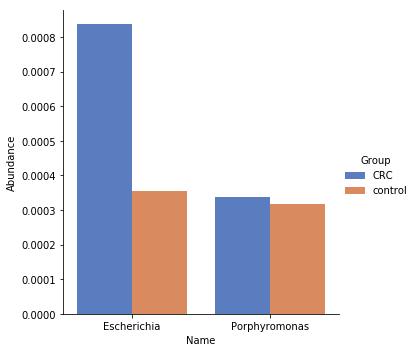

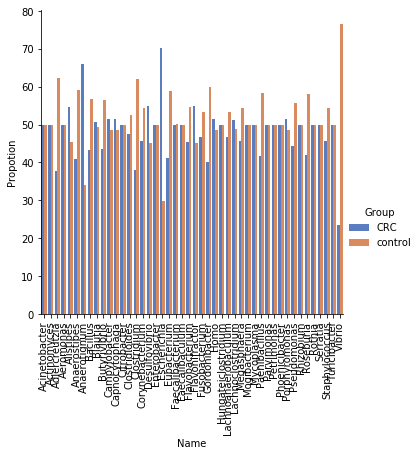

In [156]:
run("VogtmannE_2016", "Kraken", "G", 30)

Shape of table: (417, 84)
------------------- RESULTS ------------------- 
      Group  Abundance                  Name
0       CRC   0.000144         Adlercreutzia
1       CRC   0.000503  Bacteroidales_noname
2       CRC   0.000142          Butyrivibrio
3       CRC   0.001166           Escherichia
4       CRC   0.073880      Faecalibacterium
5       CRC   0.000142         Porphyromonas
6   control   0.000353         Adlercreutzia
7   control   0.001891  Bacteroidales_noname
8   control   0.000142          Butyrivibrio
9   control   0.000302           Escherichia
10  control   0.066770      Faecalibacterium
11  control   0.000142         Porphyromonas
Thrashold: 8
                                                     W  Reject null hypothesis
Name                                                                          
Porphyromonas                                       69                    True
Escherichia                                         67                    True
Bacteroidal

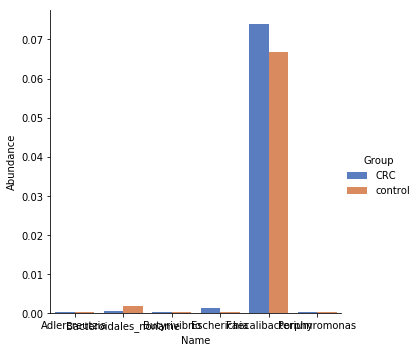

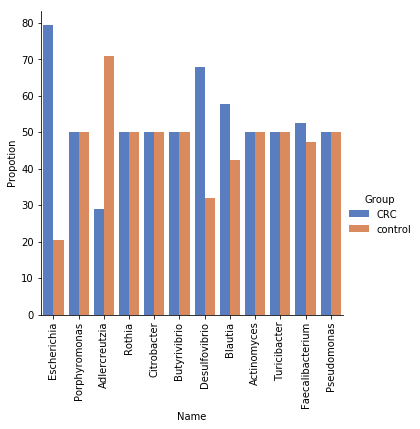

In [166]:
run("VogtmannE_2016", "Metaphlan", "G", 30, l)

Shape of table: (417, 84)
------------------- RESULTS ------------------- 
      Group  Abundance                  Name
0       CRC   0.000144         Adlercreutzia
1       CRC   0.000503  Bacteroidales_noname
2       CRC   0.000142          Butyrivibrio
3       CRC   0.001166           Escherichia
4       CRC   0.073880      Faecalibacterium
5       CRC   0.000142         Porphyromonas
6   control   0.000353         Adlercreutzia
7   control   0.001891  Bacteroidales_noname
8   control   0.000142          Butyrivibrio
9   control   0.000302           Escherichia
10  control   0.066770      Faecalibacterium
11  control   0.000142         Porphyromonas
Thrashold: 8
                                                     W  Reject null hypothesis
Name                                                                          
Porphyromonas                                       69                    True
Escherichia                                         67                    True
Bacteroidal

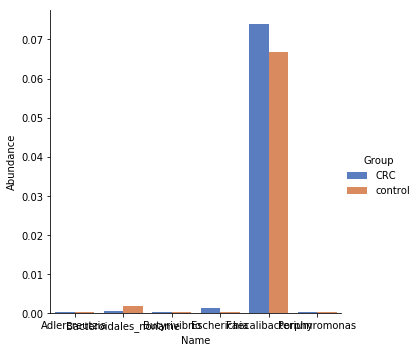

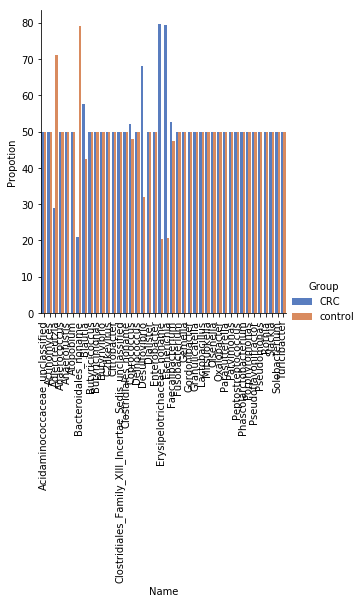

In [157]:
run("VogtmannE_2016", "Metaphlan", "G", 30)

Shape of table: (417, 145)
------------------- RESULTS ------------------- 
     Group  Abundance                  Name
0      CRC   0.006290  Bacteroides_fragilis
1      CRC   0.000803      Escherichia_coli
2  control   0.001747  Bacteroides_fragilis
3  control   0.000048      Escherichia_coli
Thrashold: 14
['Adlercreutzia_equolifaciens', 'Alistipes_senegalensis', 'Anaerostipes_hadrus', 'Anaerotruncus_colihominis', 'Bacteroidales_bacterium_ph8', 'Bacteroides_caccae', 'Bacteroides_clarus', 'Bacteroides_faecis', 'Bacteroides_fragilis', 'Bacteroides_intestinalis', 'Bacteroides_nordii', 'Bacteroides_ovatus', 'Bacteroides_uniformis', 'Bilophila_unclassified', 'Blautia_producta', 'Butyrivibrio_crossotus', 'Clostridiaceae_bacterium_JC118', 'Clostridiales_bacterium_1_7_47FAA', 'Clostridium_clostridioforme', 'Clostridium_innocuum', 'Clostridium_leptum', 'Clostridium_ramosum', 'Clostridium_symbiosum', 'Coprococcus_comes', 'Coprococcus_sp_ART55_1', 'Desulfovibrio_desulfuricans', 'Desulfovibrio_p

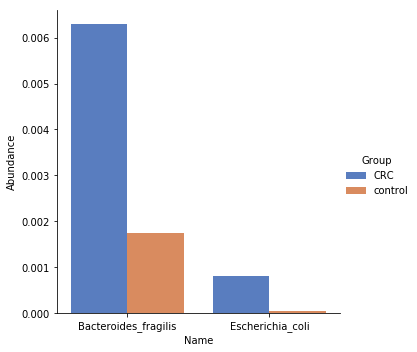

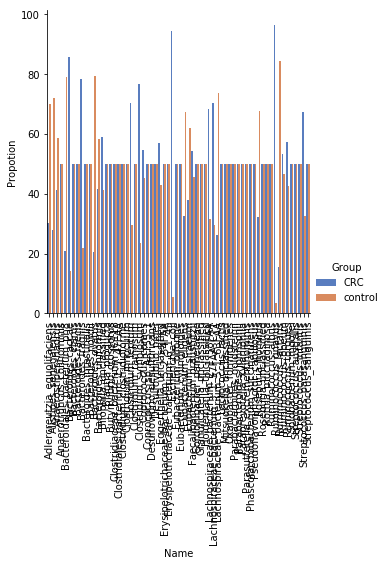

In [168]:
run("VogtmannE_2016", "Metaphlan", "S", 30)

Shape of table: (417, 95)
------------------- RESULTS ------------------- 
     Group  Abundance              Name
0      CRC   0.000826  Escherichia coli
1  control   0.000269  Escherichia coli
Thrashold: 10
['Adlercreutzia equolifaciens', 'Alistipes finegoldii', 'Anaerostipes hadrus', 'Anaerotignum propionicum', 'Bacteroides caccae', 'Bacteroides dorei', 'Bacteroides fragilis', 'Blautia sp. N6H1-15', 'Butyrivibrio fibrisolvens', 'Butyrivibrio hungatei', 'Clostridioides difficile', 'Desulfovibrio piger', 'Escherichia coli', 'Flavonifractor plautii', 'Gordonibacter pamelaeae', 'Homo sapiens', 'Lachnoclostridium phytofermentans', 'Porphyromonas gingivalis', 'Roseburia hominis', 'Ruminococcus albus', 'Ruminococcus champanellensis', 'Streptococcus parasanguinis', '[Clostridium] bolteae', '[Clostridium] sphenoides', '[Eubacterium] cellulosolvens', '[Eubacterium] eligens']
                                    W  Reject null hypothesis
Name                                                     

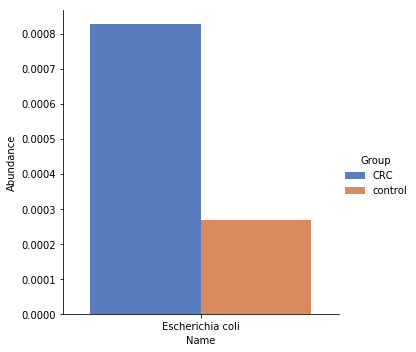

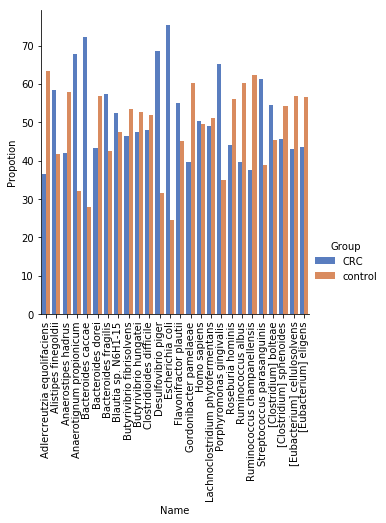

In [169]:
run("VogtmannE_2016", "Kraken", "S", 10)

In [170]:
selected_S = ['Adlercreutzia equolifaciens', 'Anaerostipes hadrus', 'Bacteroides caccae','Bacteroides fragilis',
 'Desulfovibrio piger', 'Escherichia coli', 'Gordonibacter pamelaeae', 'Roseburia hominis', 
 'Ruminococcus albus', 'Streptococcus parasanguinis']

In [173]:
selected_S_met = [name.replace(' ', '_') for name in ['Adlercreutzia equolifaciens', 'Anaerostipes hadrus', 'Bacteroides caccae','Bacteroides fragilis',
 'Desulfovibrio piger', 'Escherichia coli', 'Gordonibacter pamelaeae', 'Roseburia hominis', 
 'Ruminococcus albus', 'Streptococcus parasanguinis']]

Shape of table: (417, 95)
------------------- RESULTS ------------------- 
     Group  Abundance              Name
0      CRC   0.000826  Escherichia coli
1  control   0.000269  Escherichia coli
Thrashold: 10
['Adlercreutzia equolifaciens', 'Anaerostipes hadrus', 'Bacteroides caccae', 'Bacteroides fragilis', 'Desulfovibrio piger', 'Escherichia coli', 'Gordonibacter pamelaeae', 'Roseburia hominis', 'Ruminococcus albus', 'Streptococcus parasanguinis']
                                    W  Reject null hypothesis
Name                                                         
Escherichia coli                   94                    True
Adlercreutzia equolifaciens        75                   False
Bacteroides dorei                  69                   False
Ruminococcus champanellensis       61                   False
Desulfovibrio piger                60                   False
Ruminococcus albus                 58                   False
[Eubacterium] eligens              57             

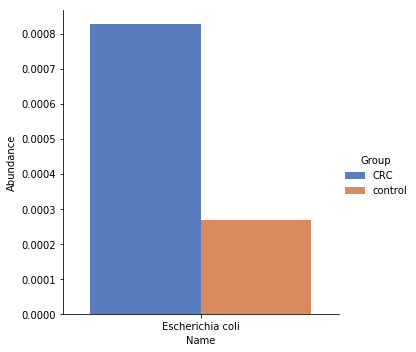

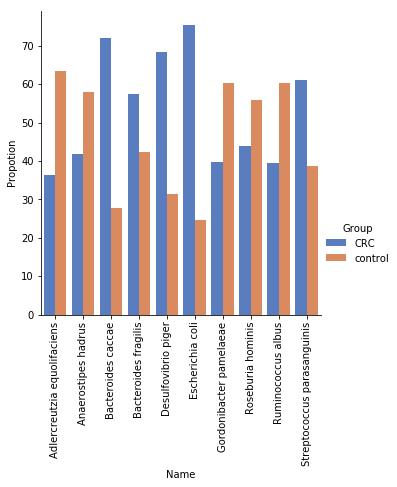

In [171]:
run("VogtmannE_2016", "Kraken", "S", 10, selected_S)

Shape of table: (417, 145)
------------------- RESULTS ------------------- 
     Group  Abundance                  Name
0      CRC   0.006290  Bacteroides_fragilis
1      CRC   0.000803      Escherichia_coli
2  control   0.001747  Bacteroides_fragilis
3  control   0.000048      Escherichia_coli
Thrashold: 14
['Adlercreutzia_equolifaciens', 'Anaerostipes_hadrus', 'Bacteroides_caccae', 'Bacteroides_fragilis', 'Desulfovibrio_piger', 'Escherichia_coli', 'Gordonibacter_pamelaeae', 'Roseburia_hominis', 'Ruminococcus_albus', 'Streptococcus_parasanguinis']
                                           W  Reject null hypothesis
Name                                                                
Escherichia_coli                         131                    True
Bacteroides_fragilis                     119                    True
Ruminococcus_gnavus                      103                   False
Bacteroidales_bacterium_ph8               97                   False
Clostridium_symbiosum          

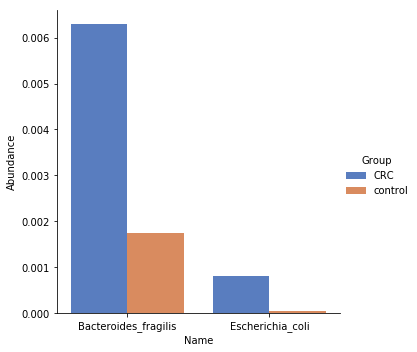

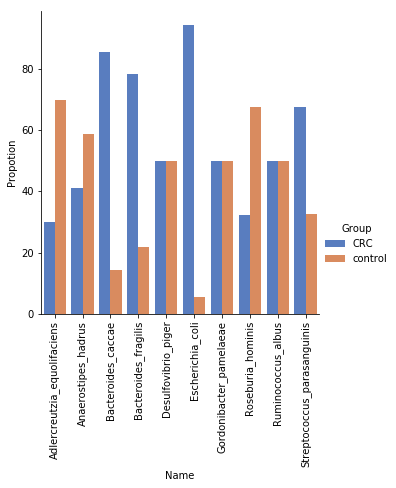

In [176]:
run("VogtmannE_2016", "Metaphlan", "S", 30, selected_S_met)

In [182]:
run("YuJ_2015", "Metaphlan", "G", 30)

Empty DataFrame
Columns: [Unnamed: 0, Sample_ID, Dataset, Rank, Name, Abundance, STUDY_CONDITION, BODY_SITE, SUBJECTID, COUNTRY, DISEASE, AGE, AGE_CATEGORY]
Index: []


WrongRank: 'g'